In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

import gmaps
import os
from config import g_key

## Cleaning Data Sets

In [2]:
#Filtering down columns for each of the 3 data sets as follows:
#Disaster Decloration Summaries - disasterNumber, state, declarationType, fyDeclared, incidentType,  
#Hazard Mitigation Assistance Projects - disasterNumber, projectType, numberOfProperties, numberOfFinalProperties, projectAmount, federalShareObligated, benefitCostRatio, netValueBenefits
#Hazard Mitigation Grant Program Disaster Summaries - disasterNumber and obligatedTotalAmount

In [3]:
#Disaster Decloration Summaries - disasterNumber, state, declarationType, fyDeclared, incidentType  
disaster_sum = pd.read_csv('DisasterDeclarationsSummaries.csv')
disaster_sum_clean = disaster_sum[['disasterNumber', 'state', 'declarationType', 'fyDeclared', 'incidentType']]
#FEMA Disaster Declarations Summary is a summarized dataset describing all federally declared disasters, beginning with the first disaster declaration in 1953
#for more information: https://www.fema.gov/openfema-data-page/disaster-declarations-summaries-v2
disaster_sum_clean.head()

,disasterNumber,state,declarationType,fyDeclared,incidentType
0,1,GA,DR,1953,Tornado
1,4,MI,DR,1953,Tornado
2,3,LA,DR,1953,Flood
3,6,MI,DR,1953,Tornado
4,2,TX,DR,1953,Tornado


In [4]:
# Get distinct disasters by state to focus on state level date
disaster_states_all = disaster_sum_clean[['disasterNumber','state','incidentType','declarationType']]
disaster_states_all = disaster_states_all.drop_duplicates()
disaster_states_all.reset_index(drop=True, inplace=True)
disaster_states_all['declarationType'].replace('DR','Major Disaster',inplace=True)
disaster_states_all['declarationType'].replace('EM','Emergency',inplace=True)
disaster_states_all['declarationType'].replace('FM','Fire Management',inplace=True)
disaster_states_all.head()

,disasterNumber,state,incidentType,declarationType
0,1,GA,Tornado,Major Disaster
1,4,MI,Tornado,Major Disaster
2,3,LA,Flood,Major Disaster
3,6,MI,Tornado,Major Disaster
4,2,TX,Tornado,Major Disaster


In [5]:
dec_type = disaster_states_all[['disasterNumber','declarationType']]
dec_type = dec_type.drop_duplicates()
dec_type.reset_index(drop=True, inplace=True)
dec_type

,disasterNumber,declarationType
0,1,Major Disaster
1,4,Major Disaster
2,3,Major Disaster
3,6,Major Disaster
4,2,Major Disaster
...,...,...
4399,3530,Emergency
4400,5323,Fire Management
4401,3531,Emergency
4402,3532,Emergency


In [6]:
dec_tsplit = dec_type[['disasterNumber','declarationType']]
# dec_tsplit = dec_type[['disasterNumber','declarationType']].groupby('declarationType').count()
dec_tsplit.head()

,disasterNumber,declarationType
0,1,Major Disaster
1,4,Major Disaster
2,3,Major Disaster
3,6,Major Disaster
4,2,Major Disaster


In [7]:
dec_tsplits = dec_type[['disasterNumber','declarationType']].groupby('declarationType').count()
dec_tsplits.head()

,disasterNumber
declarationType,
Emergency,533
Fire Management,1322
Major Disaster,2549


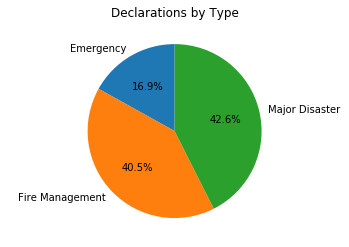

In [8]:
sums = dec_tsplit.disasterNumber.groupby(dec_tsplit.declarationType).sum()
plt.axis('equal')
plt.pie(sums, labels=sums.index, autopct='%.1f%%',startangle=90)
plt.title('Declarations by Type')
plt.savefig('pie.png')
# plt.plot(figsize=(20,10))
plt.show()

In [9]:
# Multiple states can be affected by the same disaster so for this we are 
#     purposefully showing the count of each declaration by state
disaster_states_distinct = disaster_states_all[['disasterNumber','state']].groupby('state').count()
disaster_states_distinct.head()

,disasterNumber
state,
AK,71
AL,93
AR,77
AS,16
AZ,97


In [10]:
# import state CSV for lat n lng to use on heatmap
state_ll = pd.read_csv('state_lat_lng.csv')
state_ll.head()

,state,latitude,longitude,state_name
0,AK,63.588753,-154.493062,Alaska
1,AL,32.318231,-86.902298,Alabama
2,AR,35.201050,-91.831833,Arkansas
3,AZ,34.048928,-111.093731,Arizona
4,CA,36.778261,-119.417932,California


In [11]:
US_flood_map_df = pd.merge(disaster_states_distinct, state_ll, on='state')
US_flood_map_df.head()

,state,disasterNumber,latitude,longitude,state_name
0,AK,71,63.588753,-154.493062,Alaska
1,AL,93,32.318231,-86.902298,Alabama
2,AR,77,35.201050,-91.831833,Arkansas
3,AZ,97,34.048928,-111.093731,Arizona
4,CA,323,36.778261,-119.417932,California


In [12]:
# Heat map showing states with most declared disasters 
gmaps.configure(api_key=g_key)
locations = US_flood_map_df[['latitude','longitude']].astype(float)
weights = US_flood_map_df['disasterNumber'].astype(float)
fig = gmaps.figure(center=(40.0,-100),zoom_level=5)
heat_layer = gmaps.heatmap_layer(locations,weights,
                                dissipating=False, 
                                max_intensity=359,
                                point_radius = 1)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [13]:
#Hazard Mitigation Assistance Projects - disasterNumber, projectType, numberOfProperties, numberOfFinalProperties, projectAmount, federalShareObligated, benefitCostRatio, netValueBenefits
haz_project = pd.read_csv('HazardMitigationAssistanceProjects.csv')
haz_project_clean = haz_project[['disasterNumber', 'projectType', 'numberOfProperties', 'numberOfFinalProperties', 'projectAmount', 'federalShareObligated', 'benefitCostRatio', 'netValueBenefits', 'projectIdentifier']]
#The dataset contains funded projects (financial obligation to grantee) under the Hazard Mitigation Assistance (HMA) grant programs.
#For more information: https://www.fema.gov/openfema-data-page/hazard-mitigation-assistance-projects-v2
haz_project_clean

,disasterNumber,projectType,numberOfProperties,numberOfFinalProperties,projectAmount,federalShareObligated,benefitCostRatio,netValueBenefits,projectIdentifier
0,1971.0,206.1: Safe Room (Tornado and Severe Wind Shel...,5,4,31477.0,20086.0,1.371,21420.0,DR-1971-0561-R
1,1971.0,206.1: Safe Room (Tornado and Severe Wind Shel...,4,4,19032.0,13650.0,1.371,21420.0,DR-1971-0428-R
2,1971.0,206.2: Safe Room (Tornado and Severe Wind Shel...,1,0,769334.0,577000.0,4.460,3181553.0,DR-1971-0430-R
3,1971.0,601.1: Generators,0,0,42578.0,31934.0,0.000,0.0,DR-1971-0373-F
4,1971.0,206.2: Safe Room (Tornado and Severe Wind Shel...,1,1,143899.0,107924.0,3.097,500916.0,DR-1971-0672-R
...,...,...,...,...,...,...,...,...,...
29191,NaN,700.1: Management Costs - Salaries,0,0,15000.0,11250.0,0.000,NaN,FMA-MC-08-CO-2019-002
29192,4086.0,202.2: Elevation of Private Structures - Coastal,3,1,46263.0,34626.0,0.000,0.0,DR-4086-0647-R
29193,4339.0,601.1: Generators,0,0,59885761.0,2503000.0,5.830,349133987.0,DR-4339-0016-R
29194,NaN,200.1: Acquisition of Private Real Property (S...,4,4,1246648.3,1246648.3,1.060,1321757.0,FMA-PJ-06-TX-2018-014


In [14]:
#Hazard Mitigation Grant Program Disaster Summaries
hazard_sum = pd.read_csv('HazardMitigationGrantProgramDisasterSummaries.csv')
hazard_sum_clean = hazard_sum[['disasterNumber', 'obligatedTotalAmount','lockedInCeilingAmount']]
#The dataset contains disaster level financial information for FEMA's Hazard Mitigation Grant Program (HMGP)
#For more information: https://www.fema.gov/openfema-data-page/hazard-mitigation-grant-program-disaster-summaries
hazard_sum_clean

,disasterNumber,obligatedTotalAmount,lockedInCeilingAmount
0,1071,2834575.0,2756605.0
1,1337,782081.0,950900.0
2,1326,333150.0,314981.0
3,1506,1791043.0,2192856.0
4,1211,413384.0,437358.0
...,...,...,...
1731,4551,0.0,0.0
1732,4556,0.0,0.0
1733,4553,0.0,0.0
1734,4554,0.0,0.0


In [15]:
#Looking at an overview of disasters and the Hazard mitigation projects associated with them
disaster_projects = pd.merge(haz_project_clean, disaster_sum_clean, on='disasterNumber')
disaster_summary = disaster_projects.groupby(['state','incidentType', 'disasterNumber', 'projectIdentifier']).mean()
disaster_summary

numberOfProperties  \
state incidentType    disasterNumber projectIdentifier                       
AK    Coastal Storm   4244.0         DR-4244-0001-P                      0   
                                     DR-4244-0002-P                      0   
                                     DR-4244-0003-R                      0   
                                     DR-4244-0004-F                      0   
                                     DR-4244-0007-M                      0   
...                                                                    ...   
WY    Severe Storm(s) 4007.0         DR-4007-0008-R                      0   
                                     DR-4007-0009-R                      0   
                      4306.0         DR-4306-0003-M                      0   
                                     DR-4306-0004-R                      0   
      Tornado         1599.0         DR-1599-0001-P                      0   

                                                        numberOfFinalProperties  \
state incidentType    disasterNumber projectIdentifier                            
AK    Coastal Storm   4244.0         DR-4244-0001-P                           0   
                                     DR-4244-0002-P                           0   
                                     DR-4244-0003-R                           0   
                                     DR-4244-0004-F                           0   
                                     DR-4244-0007-M                           0   
...                                                                         ...   
WY    Severe Storm(s) 4007.0         DR-4007-0008-R                           0   
                                     DR-4007-0009-R                           0   
                      4306.0         DR-4306-0003-M                           0   
                                     DR-4306-0004-R                           0   
      Tornado         1599.0         DR-1599-0001-P                           0   

                                                        projectAmount  \
state incidentType    disasterNumber projectIdentifier                  
AK    Coastal Storm   4244.0         DR-4244-0001-P           22034.0   
                                     DR-4244-0002-P           25000.0   
                                     DR-4244-0003-R           74672.0   
                                     DR-4244-0004-F           15330.0   
                                     DR-4244-0007-M           28718.0   
...                                                               ...   
WY    Severe Storm(s) 4007.0         DR-4007-0008-R         1217776.0   
                                     DR-4007-0009-R          151030.0   
                      4306.0         DR-4306-0003-M           17417.0   
                                     DR-4306-0004-R          127938.0   
      Tornado         1599.0         DR-1599-0001-P           22785.0   

                                                        federalShareObligated  \
state incidentType    disasterNumber projectIdentifier                          
AK    Coastal Storm   4244.0         DR-4244-0001-P                  16526.00   
                                     DR-4244-0002-P                  18750.00   
                                     DR-4244-0003-R                  56004.49   
                                     DR-4244-0004-F                  11498.00   
                                     DR-4244-0007-M                  28718.00   
...                                                                       ...   
WY    Severe Storm(s) 4007.0         DR-4007-0008-R                 608003.00   
                                     DR-4007-0009-R                 113273.00   
                      4306.0         DR-4306-0003-M                  17417.00   
                                     DR-4306-0004-R                  95953.50   
      Tornado         1599.0         DR

## Isolating Flood Data 

In [16]:
#From the disaster summary DF, isoloting rows with incidentType = 'Flood'
disaster_sum_clean.head()
flood = disaster_sum_clean['incidentType']=='Flood'
disaster_sum_flood = disaster_sum_clean[flood]
disaster_sum_flood = disaster_sum_flood.drop_duplicates()
disaster_sum_flood

,disasterNumber,state,declarationType,fyDeclared,incidentType
2,3,LA,DR,1953,Flood
5,8,IA,DR,1953,Flood
7,9,TX,DR,1953,Flood
8,5,MT,DR,1953,Flood
11,15,CA,DR,1954,Flood
...,...,...,...,...,...
51229,4475,ND,DR,2020,Flood
51277,4477,WI,DR,2020,Flood
57607,4519,OR,DR,2020,Flood
58946,4539,WA,DR,2020,Flood


### Calculate number of Flood disasters per state regardless of Hazard Mitigation Funding

In [17]:
#Group the Flood Disaster Summary DF by State and count 'disasterNumber'
disaster_flood_state = disaster_sum_flood.groupby('state').count()
disaster_flood_state = disaster_flood_state['disasterNumber']
print(disaster_flood_state)

state
AK    14
AL    10
AR    20
AS     1
AZ    14
CA    37
CO    13
CT     3
DE     2
FL    13
FM     1
GA     9
HI    10
IA    29
ID    17
IL    16
IN    13
KS    13
KY    24
LA    28
MA     7
MD    10
ME    13
MH     1
MI    12
MN    28
MO    23
MP     1
MS    10
MT    13
NC     8
ND    32
NE    20
NH    10
NJ     8
NM    19
NV    11
NY    25
OH    17
OK    23
OR    16
PA    26
PR     8
SC     3
SD    18
TN    18
TX    40
UT     9
VA    15
VI     3
VT    16
WA    31
WI    19
WV    30
WY     6
Name: disasterNumber, dtype: int64


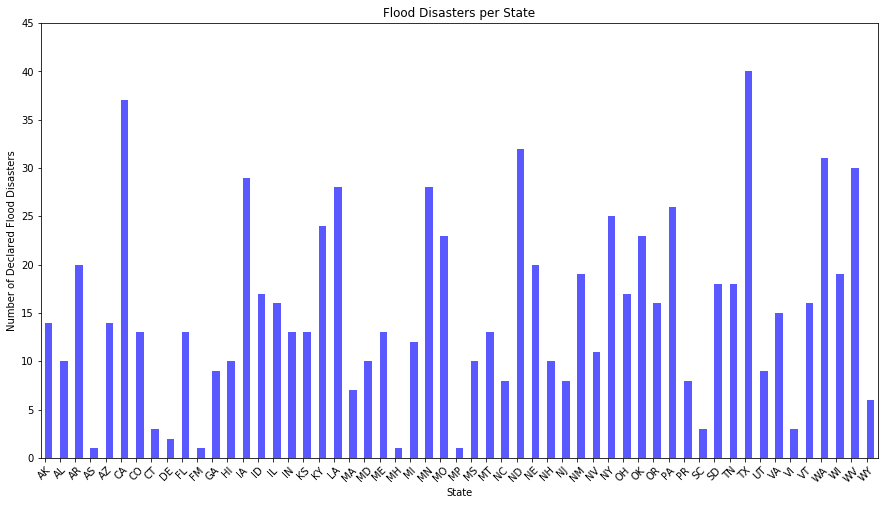

In [18]:
#Plotting the number of declared fire disasters per state
disaster_flood_state.plot(kind='bar', color='b', alpha=0.65, align="edge", figsize=(15,8), rot=45)
plt.xlabel("State")
plt.ylabel("Number of Declared Flood Disasters")
plt.title("Flood Disasters per State")
plt.xticks (rotation=45, ha='center')
plt.yticks(np.arange(0,46,5))
plt.savefig('floods_state.png')
plt.show()

# Compare Number of Flood Declarations that Resulted in a Hazard Mitigation Grant

In [19]:
# add column to each df for appropriation
update_dd = disaster_sum_flood
update_dd['dd'] = 1
update_hmg = hazard_sum_clean
update_hmg['dd'] = 1

#merge the Flood Disaster Summary DF with the Hazard Summary DF to pull in financial data 
flood_state_funding = pd.merge(update_dd, update_hmg, how='left', on='disasterNumber')
# flood_state_funding['dd_y'].replace('NaN','No',inplace=True)
flood_state_funding

C:\Users\debby\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,disasterNumber,state,declarationType,fyDeclared,incidentType,dd_x,obligatedTotalAmount,lockedInCeilingAmount,dd_y
0,3,LA,DR,1953,Flood,1,NaN,NaN,NaN
1,8,IA,DR,1953,Flood,1,NaN,NaN,NaN
2,9,TX,DR,1953,Flood,1,NaN,NaN,NaN
3,5,MT,DR,1953,Flood,1,NaN,NaN,NaN
4,15,CA,DR,1954,Flood,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
831,4475,ND,DR,2020,Flood,1,0.0,0.0,1.0
832,4477,WI,DR,2020,Flood,1,0.0,0.0,1.0
833,4519,OR,DR,2020,Flood,1,0.0,0.0,1.0
834,4539,WA,DR,2020,Flood,1,0.0,0.0,1.0


In [20]:
flood_dd_hmg = flood_state_funding[['dd_x','dd_y','incidentType']].groupby('incidentType').count()
flood_dd_hmg.columns = ['Declared Floods','Hazard Mitigation Grants']
flood_dd_hmg

,Declared Floods,Hazard Mitigation Grants
incidentType,,
Flood,836,295


### Calculate Total Obligated Amount Per State for Hazard Mitigation

In [21]:
t=flood_dd_hmg.transpose()
t

incidentType,Flood
Declared Floods,836
Hazard Mitigation Grants,295


In [22]:
#merge the Flood Disaster Summary DF with the Hazard Summary DF to pull in financial data 
flood_state_funding = pd.merge(disaster_sum_flood, hazard_sum_clean, on='disasterNumber')
flood_state_funding

,disasterNumber,state,declarationType,fyDeclared,incidentType,dd_x,obligatedTotalAmount,lockedInCeilingAmount,dd_y
0,820,UT,DR,1989,Flood,1,95048.0,90061.0,1
1,821,KY,DR,1989,Flood,1,579052.0,545000.0,1
2,824,MN,DR,1989,Flood,1,201496.0,320484.0,1
3,823,TX,DR,1989,Flood,1,0.0,0.0,1
4,822,WA,DR,1989,Flood,1,221682.0,208709.0,1
...,...,...,...,...,...,...,...,...,...
290,4475,ND,DR,2020,Flood,1,0.0,0.0,1
291,4477,WI,DR,2020,Flood,1,0.0,0.0,1
292,4519,OR,DR,2020,Flood,1,0.0,0.0,1
293,4539,WA,DR,2020,Flood,1,0.0,0.0,1


In [23]:
#group the Flood state funding DF by state and sum in order to calculate the total 'obligatedTotalAmount'
flood_state_funding_gr = flood_state_funding.groupby('state').sum()
flood_state_funding_OTA = flood_state_funding_gr['obligatedTotalAmount']
flood_state_funding_OTA

state
AK    9.802369e+06
AL    2.212540e+05
AR    2.186663e+06
AZ    9.146024e+06
CA    4.285621e+07
CO    6.269702e+07
CT    2.462960e+05
DE    3.389080e+05
FL    2.583468e+06
GA    6.330020e+05
HI    1.231685e+06
IA    9.216544e+07
ID    1.837620e+06
IL    6.141416e+07
IN    2.122349e+06
KS    1.629692e+07
KY    8.605968e+06
LA    8.170137e+07
MA    1.405048e+07
MD    4.079597e+06
ME    2.643514e+06
MH    2.053030e+05
MI    2.560494e+07
MN    5.009806e+07
MO    7.031225e+07
MS    3.117313e+06
MT    6.314542e+05
NC    2.234852e+06
ND    1.374557e+08
NE    2.767482e+07
NH    1.428150e+06
NJ    1.706576e+06
NM    1.076239e+07
NV    5.836082e+05
NY    2.165760e+07
OH    1.710260e+07
OK    9.016250e+05
OR    1.495124e+07
PA    6.303392e+07
PR    0.000000e+00
SC    3.613616e+07
SD    2.517972e+07
TN    1.564797e+06
TX    7.547734e+07
UT    3.280246e+06
VA    1.457428e+06
VT    2.820838e+06
WA    3.403618e+07
WI    9.940048e+06
WV    4.690383e+07
WY    1.605141e+06
Name: obligatedTotalAmoun

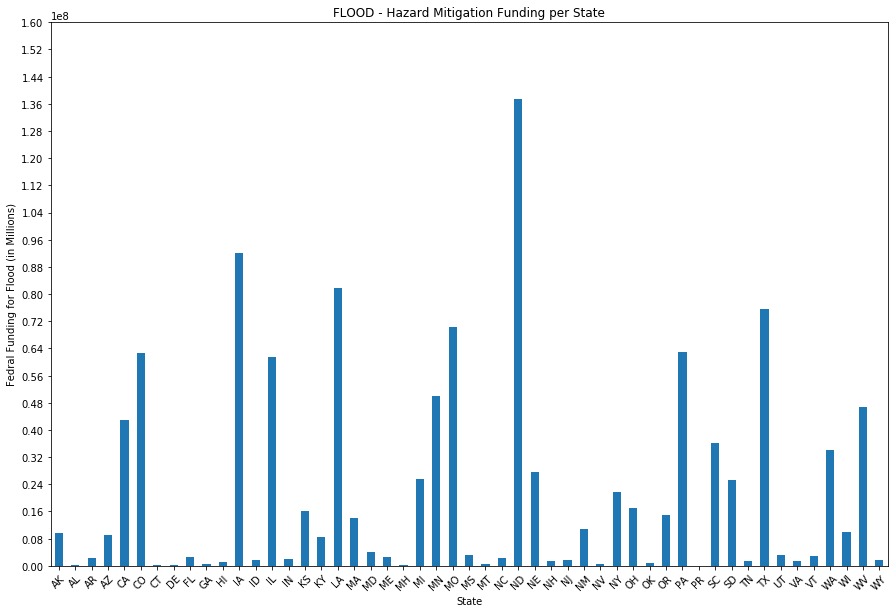

In [24]:
#Plot the amount of funding per state
flood_state_funding_OTA.plot(kind="bar", figsize=(15,10), rot=45)
# (x="state",y=['obligatedTotalAmount','lockedInCeilingAmount'],kind='bar', color='r', alpha=0.65, align="edge", figsize=(15,10), rot=45)
plt.xlabel("State")
plt.ylabel("Fedral Funding for Flood (in Millions)")
plt.title("FLOOD - Hazard Mitigation Funding per State")
plt.xticks (rotation=45, ha='center')
plt.yticks(np.arange(1.305600e+04,1.646353e+08,8e+6))
plt.savefig('flood_funding.png')
plt.show()

### Funding Through the Years for North Dakota

In [25]:
#Isolate ND's funding 
nd = flood_state_funding['state']=='ND'
nd_year_funding = flood_state_funding[nd]
nd_year_funding = nd_year_funding.groupby('fyDeclared').sum()
new_nd_year_funding = nd_year_funding['obligatedTotalAmount']
new_nd_year_funding

fyDeclared
1989      132551.00
1993     4361615.00
1997    42532037.00
1998     1959913.00
1999    11742244.00
2001     3517976.00
2010       58901.00
2011    71549737.00
2013      734810.00
2014      268862.00
2017      576314.04
2019       20788.84
2020           0.00
Name: obligatedTotalAmount, dtype: float64

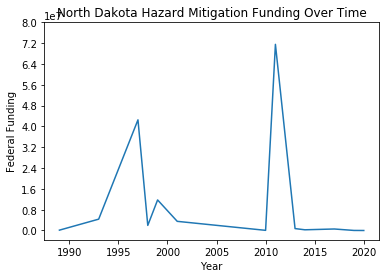

In [26]:
#plot nd's funding through the years 
nd_funding_time = new_nd_year_funding.plot.line()
plt.yticks(np.arange(0.305600e+04,.846353e+08,8e+6))
# (nd_year_funding, color="black", label="Federal Funding")
plt.title("North Dakota Hazard Mitigation Funding Over Time")
plt.xlabel("Year")
plt.ylabel("Federal Funding")
plt.savefig('nd_flood_funding.png')

Pull in census data and run a scatter plot for correlation between population and funding $ - Run the persons correlation 